In [2]:
1+1

2

In [4]:
pip install numpy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 5.3 MB 1.0 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
# 导入需要使用的库,其中numpy是支持数组和矩阵运算的科学计算库,而matplotlib是绘图库
import numpy as np
import matplotlib.pyplot as plt


class BernoulliBandit:
    """ 伯努利多臂老虎机,输入K表示拉杆个数 """
    def __init__(self, K):
        self.probs = np.random.uniform(size=K)  # 随机生成K个0～1的数,作为拉动每根拉杆的获奖
        # 概率
        self.best_idx = np.argmax(self.probs)  # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_idx]  # 最大的获奖概率
        self.K = K

    def step(self, k):
        # 当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未
        # 获奖）
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0


np.random.seed(1)  # 设定随机种子,使实验具有可重复性
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" %
      (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

Matplotlib is building the font cache; this may take a moment.


随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7203


In [9]:
class Sovler:
    "多臂老虎机算法框架"
    def __init__(self, bandit):
        self.bandit = bandit # 传入一个多臂老虎机对象
        self.counts = np.zeros(self.bandit.K) # 记录每个拉杆被拉动的次数
        self.regret = 0 # 记录总遗憾
        self.actions = [] # 记录每次选择的拉杆
        self.regrets = []   # 记录每次遗憾
        
    def update_regret(self, k):
        # 更新遗憾
        self.regret += self.bandit.best_prob - self.bandit.probs[k] # 计算遗憾
        self.regrets.append(self.regret) # 记录每次遗憾
    
    def run_one_step(self):
        raise NotImplementedError("This method should be overridden.")# 抛出异常,提示子类必须重写该方法
    
    def run(self, num_steps): # 运行多臂老虎机算法
        for _ in range(num_steps): # 循环num_steps次
            k = self.run_one_step() # 调用run_one_step方法,选择一个拉杆
            self.counts[k] += 1 # 该拉杆被拉动次数加1
            self.actions.append(k) # 记录选择的拉杆
            self.update_regret(k) # 更新遗憾

In [10]:
class EpsilonGreedy(Sovler):
    
    "ε-贪心算法"
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):# ε-贪心算法的构造函数
        super(EpsilonGreedy, self).__init__(bandit) # 调用父类的构造函数
        self.epsilon = epsilon # ε的值 # 
        self.estimates = np.array([init_prob] * self.bandit.K) # 初始化每个拉杆的获奖概率
        
    def run_one_step(self): # 选择一个拉杆
        if np.random.rand() < self.epsilon: # 以ε的概率随机选择一个拉杆
            k = np.random.choice(self.bandit.K) # 随机选择一个拉杆
        else: # 以1-ε的概率选择获奖概率最大的拉杆
            k = np.argmax(self.estimates) # 选择获奖概率最大的拉杆
        r = self.bandit.step(k) # 拉动拉杆k,获得奖励
        self.estimates[k] += 1.0 / (self.counts[k] + 1) * (r - self.estimates[k])# 更新拉杆k的获奖概率
        return k

ε-贪心算法的遗憾为21.87


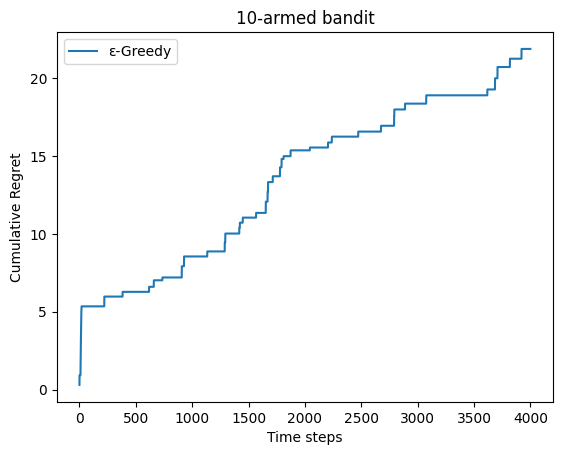

In [13]:
def plot_results(solvers, solver_names):
    """生成累计后悔随时间变化的图像。输入solvers是一个列表,
    列表中的每一个元素都是特定的策略。
    solver_names是一个列表,列表中的每一个元素都是特定策略的名称。
    """
    
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets)) # 生成时间序列
        plt.plot(time_list,solver.regrets, label=solver_names[idx]) # 绘制累计遗憾随时间变化的曲线
    plt.xlabel("Time steps") # 设置x轴标签
    plt.ylabel("Cumulative Regret") # 设置y轴标签
    plt.title('%d-armed bandit' % solvers[0].bandit.K) # 设置标题   
    plt.legend() # 显示图例 
    plt.show() # 显示图像   
    
np.random.seed(1) # 设定随机种子,使实验具有可重复性
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01) # 创建一个ε-贪心算法的对象
epsilon_greedy_solver.run(4000) # 运行1000次
print("ε-贪心算法的遗憾为%.2f" % epsilon_greedy_solver.regret) # 输出ε-贪心算法的遗憾
plot_results([epsilon_greedy_solver], ["ε-Greedy"]) # 绘制ε-贪心算法的累计遗憾随时间变化的图像
    

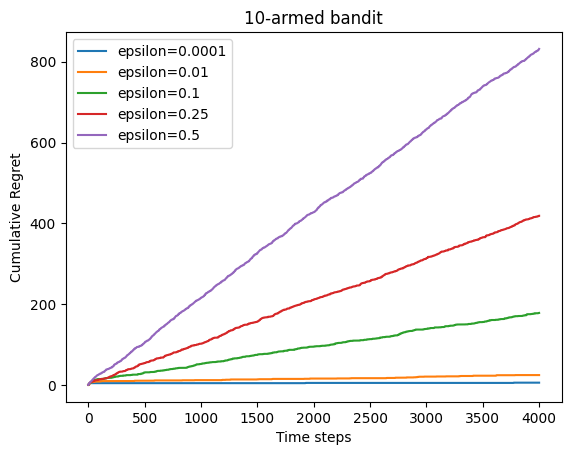

In [14]:
np.random.seed(0) # 设定随机种子,使实验具有可重复性
epsilons = [1e-4, 0.01, 0.1,0.25,0.5] # ε的值
epsilon_greedy_solver_list = [EpsilonGreedy(bandit_10_arm, epsilon) for epsilon in epsilons] # 创建多个ε-贪心算法的对象
epsilon_greedy_solver_names = ["epsilon={}".format(epsilon) for epsilon in epsilons] # ε-贪心算法的名称 
for solver in epsilon_greedy_solver_list: # 循环每个ε-贪心算法对象
    solver.run(4000) # 运行1000次   
plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names) # 绘制多个ε-贪心算法的累计遗憾随时间变化的图像